In [ ]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=e0d37bfe30f915125a299e6495e84433eb0f05c3581cd22844562dbb7015ee1a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import regex as re
import wget
import os

In [ ]:
import datetime

sd = datetime.datetime(2023,4,24).strftime("%Y%m%d")
ed = datetime.datetime(2023,4,24).strftime("%Y%m%d")

In [ ]:
import pandas as pd
ls=pd.date_range(sd,ed)

In [ ]:
dates=[dt.strftime("%Y%m%d") for dt in ls]

In [ ]:
years={date[:4] for date in dates}
months={date[4:6] for date in dates}

In [ ]:
txt=""
for year in years:
    for month in months:
        base='https://www.ngdc.noaa.gov/dscovr/data/'+year+'/'+month+'/'
        txt+=requests.get(base).text

In [ ]:
urllist=[]

In [ ]:
for date in dates:
    base='https://www.ngdc.noaa.gov/dscovr/data/'+date[:4]+'/'+date[4:6]+'/'
    x=re.search(str("oe_m1m_dscovr_s"+date+"000000_"), txt).start()
    url=base+txt[x: x+71]
    print(date,": ",url)
    urllist.append(url[46:])
    wget.download(url)

20230424 :  https://www.ngdc.noaa.gov/dscovr/data/2023/04/oe_m1m_dscovr_s20230424000000_e20230424235959_p20230425021820_pub.nc.gz


In [ ]:
import numpy as np
import torch
import xarray as xr

In [ ]:
l=len(urllist)

In [ ]:
magdata=[]

In [ ]:
for i in range(0,l):
  ds=xr.open_dataset('/content/'+urllist[i])
  df=ds.to_dataframe()
  actualdf=df.dropna()
  df_len=len(actualdf)
  for j in range(0,df_len,60):
   bx_gse_hour=np.nanmean(np.array(actualdf['bx_gse'][j:j+60]))
   by_gse_hour=np.nanmean(np.array(actualdf['by_gse'][j:j+60]))
   bz_gse_hour=np.nanmean(np.array(actualdf['bz_gse'][j:j+60]))
   magdata.append([bx_gse_hour,by_gse_hour,bz_gse_hour])

In [ ]:
magdata_numpy=np.array(magdata)

In [ ]:
magdata_torch= torch.from_numpy(magdata_numpy)

In [ ]:
import torch.nn as nn
from argparse import ArgumentParser, Namespace
import enum
from pathlib import Path
from typing import Dict
import matplotlib.pyplot as plt

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int) -> None:
        super(Seq2Seq, self).__init__()

        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dnn = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        # seq: [bs, seq_len, input_dim]
        output, hn = self.rnn(seq)
        output = self.dnn(output)
        return output

In [ ]:
model1 = Seq2Seq(3,3,3,3)
model1.load_state_dict(torch.load("/content/drive/MyDrive/dscovr_proton3.pt"))

<All keys matched successfully>

In [ ]:
m3=magdata_torch.unsqueeze(-1)

In [ ]:
datalen=m3.shape[0]

In [ ]:
m3=m3.expand(datalen,3,3)

In [ ]:
m3=m3.transpose(1,0)

In [ ]:
proton=model1(m3.float())

In [ ]:
modeld1=Seq2Seq(1,1,1,3)
modeld1.load_state_dict(torch.load('/content/drive/MyDrive/proton_to_dst_new14.pt'))


<All keys matched successfully>

In [ ]:
modeld2=Seq2Seq(1,1,1,3)
modeld2.load_state_dict(torch.load('/content/drive/MyDrive/proton_to_dst_new17.pt'))

<All keys matched successfully>

In [ ]:
modeld3=Seq2Seq(1,1,1,3)
modeld3.load_state_dict(torch.load('/content/drive/MyDrive/proton_to_dst_new18.pt'))

<All keys matched successfully>

In [ ]:
nprod1=[]
for i in range(proton.shape[1]):
  pnp=0
  for j in range(proton.shape[0]):
    pnp+=proton[j][i][0].detach().numpy()
  pnp=pnp/proton.shape[0]
  nprod1.append(pnp)

In [ ]:
nprod1_torch=torch.from_numpy(np.array(nprod1))

In [ ]:
nprod2=[]
for i in range(proton.shape[1]):
  pnp=0
  for j in range(proton.shape[0]):
    pnp+=proton[j][i][1].detach().numpy()
  pnp=pnp/proton.shape[0]
  nprod2.append(pnp)

In [ ]:
nprod2_torch=torch.from_numpy(np.array(nprod2))

In [ ]:
nprod3=[]
for i in range(proton.shape[1]):
  pnp=0
  for j in range(proton.shape[0]):
    pnp+=proton[j][i][2].detach().numpy()
  pnp=pnp/proton.shape[0]
  nprod3.append(pnp)

In [ ]:
nprod3_torch=torch.from_numpy(np.array(nprod3))

In [ ]:
dstd1=modeld1(nprod1_torch.unsqueeze(-1).float())
dstd2=modeld2(nprod2_torch.unsqueeze(-1).float())

In [ ]:
dstd3=modeld3(nprod3_torch.unsqueeze(-1).float())

In [ ]:
dstd1val=dstd1.detach().numpy()
dstd2val=dstd2.detach().numpy()
dstd3val=dstd3.detach().numpy()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
regr1=LinearRegression().fit(dstd1val[0:16].reshape(-1,1),dstd3val[0:16].reshape(-1,1))

In [ ]:
r1=regr1.predict(dstd1val.reshape(-1,1))

In [ ]:
dst=[]
ld=len(dstd2val)
for i in range(ld):
  if dstd1val[i][0]>0:
    w1=20
  else:
    w1=10
  if dstd2val[i][0]>0:
    w2=20
  else:
    w2=10
  if dstd3val[i][0]>0:
    w3=20
  else:
    w3=10
  if magdata_numpy[i][0]+magdata_numpy[i][1]+magdata_numpy[i][2]>0:
   dstval=(dstd1val[i][0])*w1+(dstd2val[i][0])*w2-r1[i][0]*w3
  elif magdata_numpy[i][0]+magdata_numpy[i][1]+magdata_numpy[i][2]<0 and dstd1val[i][0]<dstd2val[i][0]:
    dstval=-(dstd1val[i][0])*w1+(dstd2val[i][0])*w2+r1[i][0]*w3
  elif magdata_numpy[i][0]+magdata_numpy[i][1]+magdata_numpy[i][2]<0 and dstd1val[i][0]>dstd2val[i][0]:
    dstval=(dstd1val[i][0])*w1-(dstd2val[i][0])*w2+r1[i][0]*w3
  dst.append(dstval)

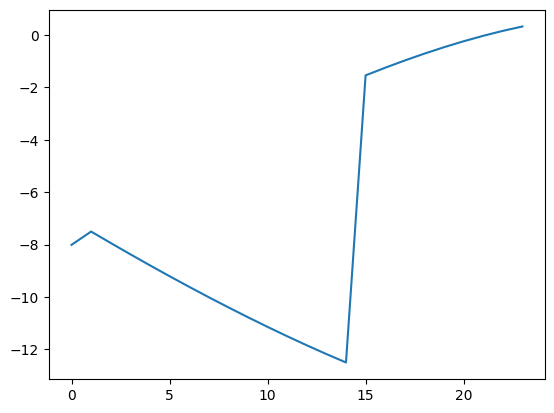

In [ ]:
plt.plot(dst)